<div align="center">
    <h1><strong>Transferencia de Calor 2D - Smith Hutton</strong></h1>
    <h2>Juan David Argüello Plata</h2>
    <img src="Images/uis.png" style="width: 300px;" />
</div>

## __1. Planteamiento del Problema__

<div align="justify">
    Se busca analizar, mediante métodos <i>numéricos</i>, el problema de transferencia de calor desarrollado por Smith Hutton, como se observa en la Figura 1.
</div>

<br>

<div align="center">
    <img src="Images/smith.png" style="width: 500px;" />
</div>

<div align="center">
    <i>Figura 1.</i> Geometría del problema.
</div>

<div align="justify">
    Se toman las siguientes suposiciones:
</div>

* Conductividad térmica constante.
* Conducción 2D.
* Sin generación.
* Campo de velocidades conocido.
* Transferencia de calor transitoria.

## __2. Datos__

<div align="justify">
    Los datos del problema se pueden especificar a continuación.
</div>

In [1]:
from App.Data import *
datos = Datos()
datos

### __3. Mallado__

<div align="justify">
    La formulación del mallado se realiza a partir de una <i>malla escalonada</i>, donde las variables escalares (presión y temperatura) son datos que se almacenan en los nodos, mientras que las velocidades se localizan en las caras de los elementos. Esto se puede apreciar ligeramente en la discretización del dominio desarrollada a través de la ejecución del siguiente algoritmo:
</div>

In [2]:
%matplotlib inline
from App.Preprocessing.Mesh import Malla
import sqlite3 as sql
from ipywidgets import *
def Mesh(xsub,ysub, numN = False):
    Malla((data['Geometría']['W']/xsub,
           data['Geometría']['H']/ysub),
           (data['Propiedades']['T_0'],
            data['Propiedades']['T_{infty}']),
           False,
           (numN, False),
           data['Geometría'])
    #Conexión con base de datos
    con = sql.connect('App/data.db')
    text = ["SELECT * FROM ", " ORDER BY ", " DESC LIMIT 1"]
    n =  con.execute(text[0]+' nodes '+text[1]+' NodeID '+text[2]).fetchall()
    el = con.execute(text[0]+' elements '+text[1]+' ElID '+text[2]).fetchall()
    con.close()
    display(HTML("Número de nodos: " + str(n[0][0])))
    display(HTML("Número de elementos: " + str(el[0][0])))
    return data['Geometría']['W']/xsub, data['Geometría']['H']/ysub, xsub, ysub
data = Read(datos)
ElData = interactive(Mesh,
                     xsub=IntSlider(value=4, max=14, min = 4, step=2),
                     ysub=IntSlider(value=4, max=14, min = 4, step=2),
                     numN = False, 
                     continous_update=False)
display(ElData)

interactive(children=(IntSlider(value=4, description='xsub', max=14, min=4, step=2), IntSlider(value=4, descri…

### __4. Planteamiento y solución del sistema matricial__

<div align="justify">
    El planteamiento matricial se desarrolla con base en las siguietes relaciones matemáticas:
    $$
    \begin{equation}
        a_p T_p = a_E T_E + a_W T_W + a_N T_N + a_S T_S + b
        \tag{3}
        \label{Ts}
    \end{equation}
    $$
    $$
    \begin{equation}
        u = 2y \left(1-x^2 \right) \\
        v = -2x \left(1-y^2 \right) \\
        T_{izq} = 1+tanh(10) (2x+1)
    \end{equation}
    $$
    Dónde $b$ es la generación de calor y: 
    $$
    \begin{equation}
        a_p = a_E + a_W + a_N + a_S + a_{p0} + \left(F_E-F_W+F_N-F_S \right) \\
        F_E = F_W = \rho u \Delta y \\
        F_N = F_S = \rho v \Delta x \\
        D_E = D_W = K \frac{\Delta y}{\Delta x} \\
        D_N = D_S = K \frac{\Delta x}{\Delta y} \\
        a_{p0} = \rho \frac{\Delta x \Delta y}{\Delta t} \\
        b = a_{p0} T _p ^0 + Q_g \Delta x \Delta y \\
        a_E = D_E A_{pE} + max \left(-F_E,0 \right) \\
        a_W = D_W A_{pW} + max \left(F_W,0 \right) \\
        a_N = D_N A_{pN} + max \left(-F_N,0 \right) \\
        a_S = D_S A_{pS} + max \left(F_S,0 \right) \\
        A_{pi} = 1-0.5 \mid P_i \mid \rightarrow \text{Diferencias centradas} \\
        A_{pi} = 1 \rightarrow \text{Upwind} \\
        A_{pi} = max \left(0 \, , 1-0.5 \mid P_i \mid \right) \rightarrow \text{Híbrido} \\
        P_i = \frac{F_i}{D_i} = \frac{\rho u A_j}{K} \\
        A_x = \Delta x \Delta z \\
        A_y = \Delta y \Delta z \\
        \frac{\rho}{K} = 10^6 \, o \, 10^3 \, o \, 10
    \end{equation}
    $$
    Para la malla mostrada anteriormente, el sistema de ecuaciones general es el siguiente:
</div>

In [3]:
from sympy import init_session
init_session(use_latex=True)

IPython console for SymPy 1.4 (Python 3.7.4-32-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.4/



__Reemplazando__ las ecuaciones anteriores en la Ecuación 3, se obtiene la siguiente relación matemática para la temperatura centroidal:

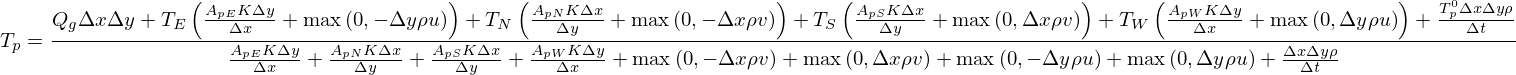

In [4]:
from sympy.functions import Min, Max
#Creación de símbolos generales
a_p, a_S, a_N, a_E, a_W, T_p, T_S, T_N, T_E, T_W, u, v, x, y, a_p0, b, F_S, F_N, F_E, F_W, D_S, D_N, D_E, D_W, Q_g = \
    symbols("a_p, a_S, a_N, a_E, a_W, T_p, T_S, T_N, T_E, T_W, u, v, x, y, a_{p0}, b, F_S, F_N, F_E, F_W, D_S, D_N, D_E, D_W, Q_g")
Dx, Dy, Dt, T_p0 = Symbol("\\Delta x"), Symbol("\\Delta y"), Symbol("\\Delta t"), Symbol("T_p ^0")
rho, A, K = symbols("\\rho, A, K")
A_pE, A_pW, A_pN, A_pS = symbols("A_{pE}, A_{pW}, A_{pN}, A_{pS}")

#Ecuaciones
a_p0 = rho*(Dx*Dy)/Dt
D_E = K*(Dy/Dx)
D_W = D_E
D_N = K*(Dx/Dy)
D_S = D_N
F_E = rho*u*Dy
F_W = rho*u*Dy
F_N = rho*v*Dx
F_S = rho*v*Dx
u = 2*y*(1-x**2)
v = -2*x*(1-y**2)
b = a_p0*T_p0 + Q_g*Dx*Dy
a_E = D_E*A_pE+Max(-F_E,0)
a_W = D_W*A_pW+Max(F_W,0)
a_S = D_S*A_pS+Max(F_S,0)
a_N = D_N*A_pN+Max(-F_N,0)
a_p = a_E+a_W+a_S+a_N+a_p0+(F_E-F_W+F_N-F_S)
Ec = Eq(T_p, (1/a_p)*(a_E*T_E + a_W*T_W + a_N*T_N + a_S*T_S + b))
Ec

## __5. Resultados $\rightarrow$ Postprocesamiento__

Los resultados obtenidos se pueden evidenciar a continuación:

In [5]:
%matplotlib inline
from ipywidgets import *
from App.Solver import Solve
#Constantes Generales
Cons = {}
Cons[Dx], Cons[Dy], Cons["xsub"], Cons["ysub"] = ElData.result
Cons[K], Cons[Q_g] = data['Propiedades']['K'], data['Propiedades']['Q_g']
Cons[Dt] = data['Propiedades']['Dt']
Ec = Ec.subs(Cons)

def Solver(Tipo, Peclet, Iteraciones): 
    Solve(Ec, Tipo, Peclet, data, Cons[Dx], Cons[Dy], Iteraciones, 
          (data['Geometría']['W'], data['Geometría']['H']), (Cons["ysub"],Cons["xsub"]))

ss = interactive(Solver,
                Tipo = RadioButtons(options=['Upwind', 'Diferencias Centradas', 'Híbrido'], value='Híbrido'),
                Peclet = RadioButtons(options=[10.0, 1000.0, 10E6], value=10),
                Iteraciones = IntText(value=10))
display(ss)

interactive(children=(RadioButtons(description='Tipo', index=2, options=('Upwind', 'Diferencias Centradas', 'H…

A continuación, se pueden apreciar __todos__ los resultados...

HTML(value='<h1 align="center"><strong>Resultados tipo Upwind</strong></h1>')

## _Peclet:_ 10.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

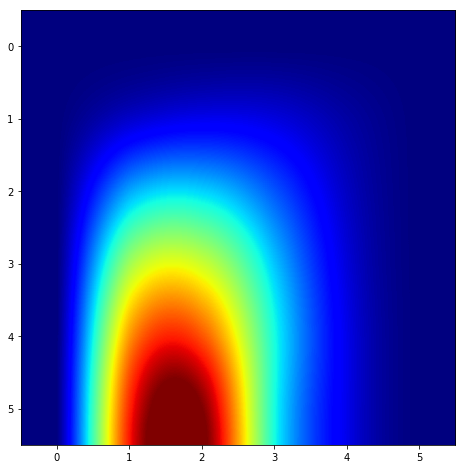

## _Peclet:_ 1000.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

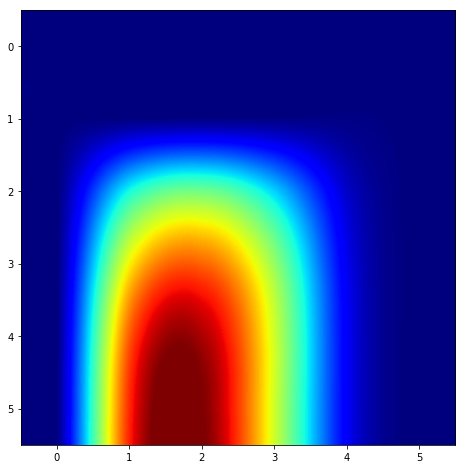

## _Peclet:_ 10000000.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

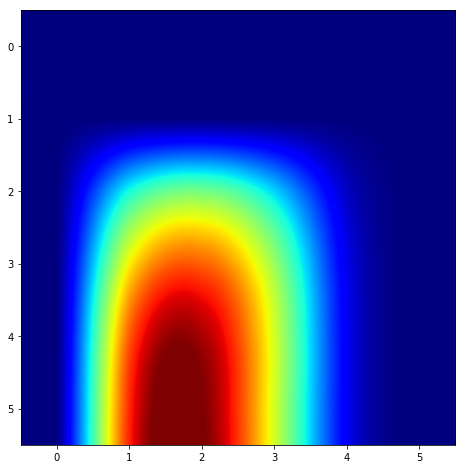

HTML(value='<h1 align="center"><strong>Resultados tipo Diferencias Centradas</strong></h1>')

## _Peclet:_ 10.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

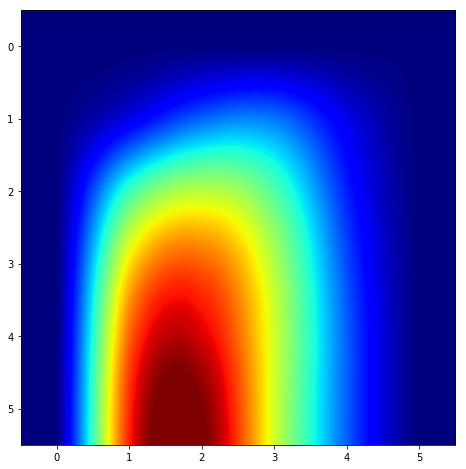

## _Peclet:_ 1000.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

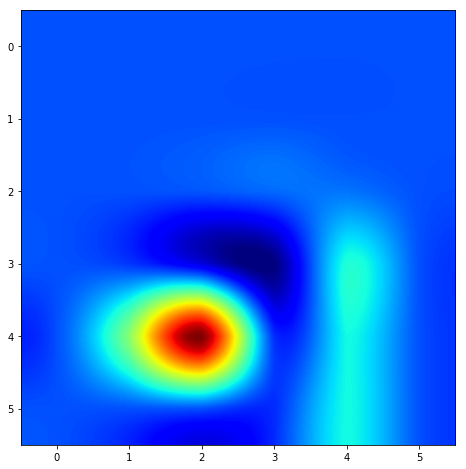

## _Peclet:_ 10000000.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

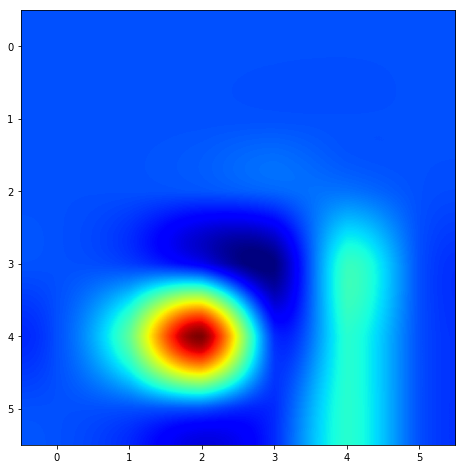

HTML(value='<h1 align="center"><strong>Resultados tipo Híbrido</strong></h1>')

## _Peclet:_ 10.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

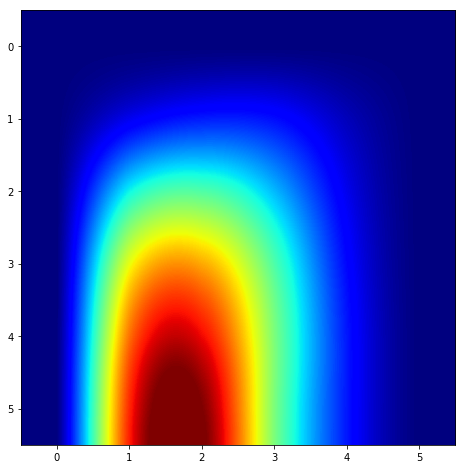

## _Peclet:_ 1000.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

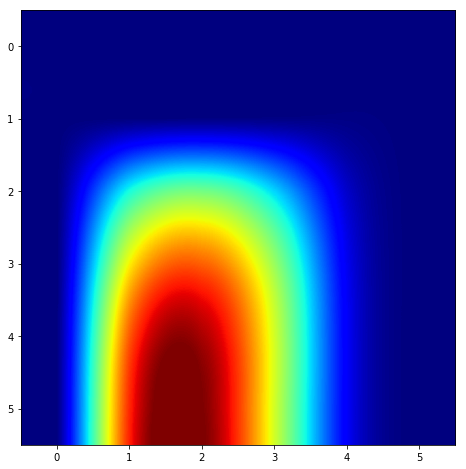

## _Peclet:_ 10000000.0

_Progreso..._

FloatProgress(value=0.0, max=340.0)

__Resultados:__

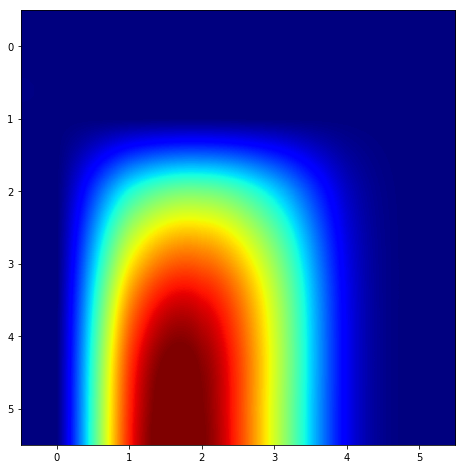

In [6]:
%matplotlib inline
from IPython.display import display, Markdown, HTML
from ipywidgets import *
from App.Solver import Solve

#Constantes Generales
Cons = {}
Cons[Dx], Cons[Dy], Cons["xsub"], Cons["ysub"] = ElData.result
Cons[K], Cons[Q_g] = data['Propiedades']['K'], data['Propiedades']['Q_g']
Cons[Dt] = data['Propiedades']['Dt']
Ec = Ec.subs(Cons)

for Tipo in ['Upwind', 'Diferencias Centradas', 'Híbrido']:
    display(HTML('<h1 align="center"><strong>Resultados tipo ' + Tipo + "</strong></h1>"))
    for Peclet in [10.0, 1000.0, 10E6]:
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
        display(Markdown("## _Peclet:_ " + str(Peclet)))
        Solve(Ec, Tipo, Peclet, data, Cons[Dx], Cons[Dy], 5, 
          (data['Geometría']['W'], data['Geometría']['H']), (Cons["ysub"],Cons["xsub"]), 
             fig=(False,ax,fig))
        